# Lab 3


In [1]:
try:
    from google.colab import files
    print("Upload 'Global finance data.csv' file")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
except Exception:
    fname = "Global finance data.csv"


Upload 'Global finance data.csv' file


Saving Global finance data.csv to Global finance data.csv


,Country,Date,Stock_Index,Index_Value,Daily_Change_Percent,Market_Cap_Trillion_USD,GDP_Growth_Rate_Percent,Inflation_Rate_Percent,Interest_Rate_Percent,Unemployment_Rate_Percent,...,Commodity_Index,Oil_Price_USD_Barrel,Gold_Price_USD_Ounce,Bond_Yield_10Y_Percent,Credit_Rating,Political_Risk_Score,Banking_Sector_Health,Real_Estate_Index,Export_Growth_Percent,Import_Growth_Percent
0,United States,2024-08-15,S&P_500,5437.2,0.34,51.2,2.8,2.9,5.50,3.7,...,1.12,77.85,2487.5,4.25,AAA,8.1,Strong,145.6,3.2,2.8
1,China,2024-08-15,Shanghai_Composite,2891.6,-0.82,12.4,5.2,0.8,3.10,5.2,...,0.98,77.85,2487.5,2.15,A+,6.7,Moderate,98.7,8.9,6.1
2,Japan,2024-08-15,Nikkei_225,36789.1,1.24,6.8,0.9,2.8,-0.10,2.4,...,1.05,77.85,2487.5,0.89,A+,8.4,Strong,89.3,5.1,4.7
3,Germany,2024-08-15,DAX,18234.5,0.67,2.9,0.3,2.2,4.50,3.1,...,1.08,77.85,2487.5,2.31,AAA,8.7,Strong,112.4,2.1,1.8
4,United Kingdom,2024-08-15,FTSE_100,8156.3,-0.15,3.1,1.1,2.0,5.25,4.2,...,1.06,77.85,2487.5,3.89,AA,7.9,Moderate,97.8,0.9,1.2


{'MSE_CV': 77207666084.1969, 'R2_CV': -0.2725400837059744, 'n_samples': 39}


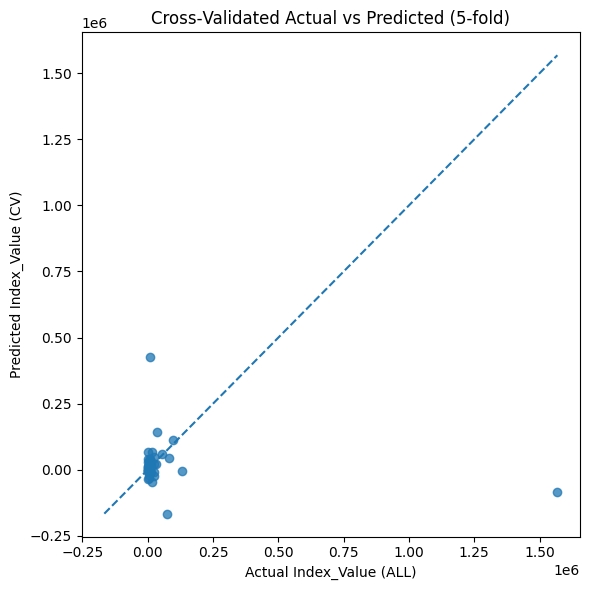

In [2]:

import json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv(fname)
display(df.head())

target = "Index_Value"
X = df.drop(columns=[target])
y = df[target]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# Optional: enrich Date
if "Date" in X.columns:
    try:
        dt = pd.to_datetime(df["Date"])
        X["Year"] = dt.dt.year
        X["Month"] = dt.dt.month
        num_cols += [c for c in ["Year","Month"] if c not in num_cols]
        if "Date" in cat_cols:
            cat_cols.remove("Date")
    except:
        pass

preprocess = ColumnTransformer([
    ("num", Pipeline([("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
])

pipe = Pipeline([("prep", preprocess), ("model", LinearRegression())])

# 5-fold CV on the ENTIRE dataset
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_cv_pred = cross_val_predict(pipe, X, y, cv=cv)

mse_cv = mean_squared_error(y, y_cv_pred)
r2_cv = r2_score(y, y_cv_pred)
print({"MSE_CV": mse_cv, "R2_CV": r2_cv, "n_samples": len(y)})

# Plot (ALL points)
plt.figure(figsize=(6,6))
plt.scatter(y, y_cv_pred, alpha=0.75)
mn, mx = min(y.min(), y_cv_pred.min()), max(y.max(), y_cv_pred.max())
plt.plot([mn, mx],[mn, mx], linestyle="--")
plt.xlabel("Actual Index_Value (ALL)"); plt.ylabel("Predicted Index_Value (CV)")
plt.title("Cross‑Validated Actual vs Predicted (5-fold)")
plt.tight_layout()
plt.savefig("pred_vs_actual_all.png", dpi=150)
plt.show()

# Save metrics
with open("regression_metrics_cv.json","w") as f:
    json.dump({"MSE_CV": mse_cv, "R2_CV": r2_cv, "n_samples": int(len(y))}, f, indent=2)
